In [1]:
import os
import h5py
import numpy as np
from astropy.io import fits
from astropy import table as aTable
from desispec.io import read_spectra

In [2]:
# lets install the python package `provabgs`, a python package for generating the PRObabilistic Value-Added BGS (PROVABGS)
!pip uninstall -y provabgs
!pip install git+https://github.com/changhoonhahn/provabgs.git --upgrade --user
!pip install zeus-mcmc --user

Found existing installation: provabgs 0.1
Uninstalling provabgs-0.1:
  Successfully uninstalled provabgs-0.1
  Cloning https://github.com/changhoonhahn/provabgs.git to /tmp/pip-req-build-okmf8cea
  Running command git clone --filter=blob:none -q https://github.com/changhoonhahn/provabgs.git /tmp/pip-req-build-okmf8cea
  Resolved https://github.com/changhoonhahn/provabgs.git to commit 3c64e929dc392041a4537fd2c4297fe588a2687c
  Preparing metadata (setup.py) ... done
  Created wheel for provabgs: filename=provabgs-0.1-py3-none-any.whl size=39795620 sha256=8d6a46567f925030a4661ba84e8f45450e650c504626b2a590ee43414b299d86
  Stored in directory: /tmp/pip-ephem-wheel-cache-puxd033m/wheels/7e/3c/9e/fc1ba34fdd1cb4b872903148b049da1312594804e05d1bf0cc
Successfully built provabgs


In [3]:
from provabgs import util as UT
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import flux_calib as FluxCalib

/global/homes/c/chahah/.local/lib/python3.9/site-packages/provabgs/models.py:23: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [4]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [5]:
dat_dir = '/global/homes/k/koposov/desi_koposov/m31_processing_scripts/reduction_2205/data/'

## read coadd, vrad, redrock files

In [6]:
coadd = read_spectra(os.path.join(dat_dir, 'coadd_m31_all_220521.fits'))

INFO:spectra.py:291:read_spectra: iotime 15.776 sec to read coadd_m31_all_220521.fits at 2022-06-10T13:44:53.515337


In [7]:
zbest = aTable.Table.read(os.path.join(dat_dir, 'redrock_m31_all_220521.fits'))

In [8]:
vrad = aTable.Table.read(os.path.join('/global/cscratch1/sd/chahah/provabgs/', 'All_clusters_M31.fits'))

In [9]:
rvtab = aTable.Table.read(os.path.join(dat_dir, 'rvtab_coadd_m31_all_220521.fits'))

In [10]:
targid = coadd.target_ids()

In [11]:
igals_coadd, igals_rvtab = [], []
for tid in vrad['TARGETID']: 
    assert np.sum(targid == tid) == 1
    igals_coadd.append(np.arange(len(targid))[targid == tid][0])
    
    assert np.sum(rvtab['TARGETID'] == tid) == 1
    igals_rvtab.append(np.arange(len(rvtab))[rvtab['TARGETID'] == tid][0])

(0.0, 15.0)

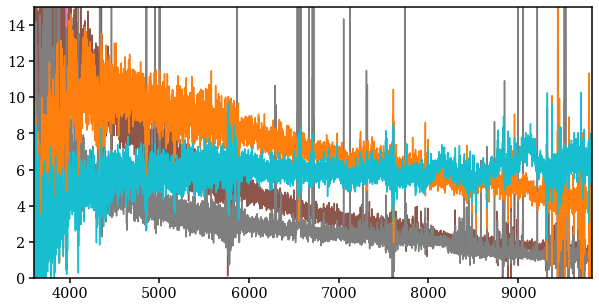

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for igal in igals_coadd[:5]: 
    sub.plot(coadd.wave['b'], coadd.flux['b'][igal], c='C%i' % igal)
    sub.plot(coadd.wave['r'], coadd.flux['r'][igal], c='C%i' % igal)
    sub.plot(coadd.wave['z'], coadd.flux['z'][igal], c='C%i' % igal)
sub.set_xlim(coadd.wave['b'].min(), coadd.wave['z'].max())
sub.set_ylim(0, 15)

## fit spectra using `provabgs`

In [18]:
# declare prior
priors = Infer.load_priors([
    Infer.UniformPrior(0., 10, label='sed'),
    Infer.FlatDirichletPrior(4, label='sed'), 
    Infer.UniformPrior(0., 1., label='sed'), 
    Infer.LogUniformPrior(1e-2, 13.27, label='sed'), 
    Infer.UniformPrior(np.array([6.9e-5, 6.9e-5, 0., 0., -2.2]),
                       np.array([7.3e-3, 7.3e-3, 3., 4., 0.4]), label='sed')
    ])

# declare model
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [19]:
desi_mcmc = Infer.desiMCMC(
    model=m_nmf, 
    prior=priors
)

In [ ]:
for ii, igal in zip(range(7,8), igals_coadd[7:8]): 
    
    zred = vrad['VRAD'][ii] / 299792.458 
    print(zred)
    
    desi_mcmc = Infer.desiMCMC(
        model=m_nmf, 
        prior=priors)
    
    mcmc = desi_mcmc.run(
        wave_obs=[coadd.wave['b'], coadd.wave['r'], coadd.wave['z']],
        flux_obs=[coadd.flux['b'][igal], coadd.flux['r'][igal], coadd.flux['z'][igal]],
        flux_ivar_obs=[coadd.ivar['b'][igal], coadd.ivar['r'][igal], coadd.ivar['z'][igal]],
        zred=zred, 
        sampler='zeus',
        nwalkers=100, 
        burnin=100,
        opt_maxiter=10000,
        niter=1000, 
        debug=True)

0.0007166869550635152
--- initializing the walkers ---
initial theta = [5.117107457194891, 0.661857662239237, 0.6121321109763744, 0.7854947056008288, 0.9999638891851542, 1.2503518663564384, 0.0030169942242126374, 0.0032578759220048895, 1.468509983442499, 0.59027942223211, -1.5087660011091089]
log Posterior(theta0) = -11385.026003
--- running MCMC ---


Initialising ensemble of 100 walkers...
Sampling progress :   0%|          | 5/1100 [00:57<3:17:07, 10.80s/it]